In [1]:
import warnings
import pandas as pd

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
df = pd.read_csv("data/dataset-loslagos-8months.csv"
                 ,sep=";", 
                 engine='python'
                )
df.columns = ["date", "media_outlet", "url", "title", "text"]
df["content"] = ""
df.content = df.title + " " + df.text
print("Largo del dataset: ", len(df))
df.head()

Largo del dataset:  29598


,date,media_outlet,url,title,text,content
0,2021-10-01,elheraldoaustral,https://www.eha.cl/noticia/local/reconocen-a-g...,Reconocen a guardaparques de la Región de Los ...,Distintos protagonistas de los parques naciona...,Reconocen a guardaparques de la Región de Los ...
1,2021-10-01,elheraldoaustral,https://www.eha.cl/noticia/local/con-nuevos-ma...,Con nuevos materiales comienza plan piloto en ...,Centro de negocios Sercotec coordina acuerdos ...,Con nuevos materiales comienza plan piloto en ...
2,2021-10-01,elheraldoaustral,https://www.eha.cl/noticia/local/centro-de-sal...,Centro de Salud Familiar CESFAM Puerto Varas i...,Las horas se solicitan en el SOME o bien a tra...,Centro de Salud Familiar CESFAM Puerto Varas i...
3,2021-10-01,elheraldoaustral,https://www.eha.cl/noticia/local/alcalde-tomas...,Alcalde Tomás Gárate presidió por primera vez ...,Los y las consejeras destacaron el hecho de vo...,Alcalde Tomás Gárate presidió por primera vez ...
4,2021-10-01,elheraldoaustral,https://www.eha.cl/noticia/local/galeria-de-ar...,Galería de Arte Machacoya realizará remate de ...,"Hoy viernes a las 18:30 horas, en Machacoya At...",Galería de Arte Machacoya realizará remate de ...


In [6]:
week = df.loc[df.date == "2021-12-22"].dropna()
len(week)

207

In [11]:
comunas = ["ancud", "castro", "chonchi", "curaco de velez", "dalcahue", 
           "puqueldon", "queilen", "quemchi", "quellon", "quinchao"
           "calbuco", "cochamo", "fresia", "frutillar", "llanquihue"
           "los muermos", "maullin", "puerto montt", "puerto varas", "osorno"
           "puerto octay", "purranque", "puyehue", "rio negro", "san juan de la costa",
           "san pablo", "chaiten", "futaleufu", "hualaihue", "palena"]

In [15]:
from tqdm.notebook import tqdm_notebook
import unidecode

df['comuna'] = ""
for index, row in tqdm_notebook(df.iterrows(), desc="buscando comunas en content"):
    unaccented = unidecode.unidecode(str(row["content"]).lower()) 
    # a veces tira que es float, probablemente esto se deba a un problema en el formato del dataset
    
    found = [comuna for comuna in comunas if(comuna in unaccented)]
    if(len(found)!= 0): df.at[index, 'comuna'] = found

buscando comunas en content: 0it [00:00, ?it/s]

In [17]:
selection = ['puerto montt']
mask = df.comuna.apply(lambda x: any(item for item in selection if item in x))

df1 = df[mask]
df1.head()

,date,media_outlet,url,title,text,content,comuna
7,2021-10-01,seminariolocal,https://www.semanariolocal.cl/archivos/2207,Gremio médico rechaza cierre de camas críticas...,El Capítulo Médico Ancud y el Consejo Regional...,Gremio médico rechaza cierre de camas críticas...,"[ancud, puerto montt]"
14,2021-10-01,elrepuertero,https://www.elrepuertero.cl/noticia/sociedad/c...,Conductores del DAEM Puerto Montt llegan a acu...,"Durante la jornada de este jueves, los conduct...",Conductores del DAEM Puerto Montt llegan a acu...,[puerto montt]
22,2021-10-01,elheraldoaustral,https://www.eha.cl/noticia/local/audiencia-de-...,Audiencia de Preparación de Juicio Oral será e...,Piden condena de 5 años y un día Piden condena...,Audiencia de Preparación de Juicio Oral será e...,"[puerto montt, puerto varas]"
25,2021-10-01,radioacogida,https://radioacogida.cl/vialidad-y-gobernador-...,VIALIDAD Y GOBERNADOR REGIONAL COMPROMETEN IMP...,Hasta la comuna de Puerto Montt se trasladó un...,VIALIDAD Y GOBERNADOR REGIONAL COMPROMETEN IMP...,"[puerto montt, purranque]"
30,2021-10-01,radiosago,https://www.radiosago.cl/23-nuevos-contagios-d...,23 nuevos contagios de covid-19 presentó la re...,Fueron 2.115 las muestras de exámenes PCR anal...,23 nuevos contagios de covid-19 presentó la re...,"[castro, quellon, puerto montt, chaiten, futal..."


### [Topic Modelling in Embedding Spaces](https://github.com/lffloyd/embedded-topic-model)

Read please: https://arxiv.org/pdf/1907.04907.pdf

In [22]:
#!python -m spacy download es_core_news_md
#!pip install -U embedded_topic_model
!python -m spacy validate


| Loading compatibility table...
/ Loading compatibility table...
- Loading compatibility table...
\ Loading compatibility table...
| Loading compatibility table...
/ Loading compatibility table...
- Loading compatibility table...
[+] Loaded compatibility table

================= Installed pipeline packages (spaCy v3.3.0) =================
[i] spaCy installation:
C:\Users\56981\miniconda3\envs\etm\lib\site-packages\spacy

NAME              SPACY                 VERSION      
es_core_news_md   >=3.3.0.dev0,<3.4.0   3.3.0     [+]
es_core_news_sm   >=3.3.0.dev0,<3.4.0   3.3.0     [+]



In [23]:
import torch 
import spacy

nlp = spacy.load("es_core_news_sm")

print(torch.__version__)

1.6.0


In [24]:
def spacy_tokenizer(texto):
    # crea lista de tokens a partir de un texto
    mytokens = []
    doc = nlp(texto.lower().strip())
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and not token.like_num:
            mytokens.append(token.lemma_)
    return mytokens

In [25]:
noticias = week.content #POR MIENTRAS, SOLO TRABAJARÉ CON UNA SEMANA!!!!!

In [26]:
import re
from sklearn.feature_extraction.text import CountVectorizer

myStopWords=['gnl','=','$','+','a','e','o','u','y',' ','  ','   ','    ']
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                stop_words=myStopWords,tokenizer=spacy_tokenizer, ngram_range=(1,1))

tf = tf_vectorizer.fit_transform(noticias)
diccionario= tf_vectorizer.get_feature_names()

In [27]:
#preparando los datos para su análisis y visualización
import numpy as np
from tqdm import tqdm # Barra de progreso

td= {'tokens':[],'counts':[]}
doc_l = np.zeros(len(noticias))
term_f= np.zeros(len(diccionario))
for i in tqdm(range(0,len(noticias))):
        tok=[]
        cou=[]
        for j in range(0,len(diccionario)):
             if(tf[i,j]>=1):
                term_f[j] = term_f[j] + tf[i,j]
                doc_l[i] = doc_l[i]+ tf[i,j]
                tok.append(j)
                cou.append(tf[i,j])
        td['tokens'].append(np.array(tok))
        td['counts'].append(np.array(cou))
td['tokens']= np.array(td['tokens'],dtype=object)
td['counts']= np.array(td['counts'],dtype=object)

100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [00:17<00:00, 11.58it/s]


Cargar un modelo Word2Vec pre-entrenado para el español         
Ver: https://github.com/dccuchile/spanish-word-embeddings

##### Word2Vec embeddings from SBWC
Links to the embeddings (#dimensions=300, #vectors=1,000,653): 
[Vector format (.txt.bz2)](http://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2)

In [28]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("data/SBW-vectors-300-min5.bin.gz", binary=True) 

In [29]:
from embedded_topic_model.models.etm import ETM
# Training an ETM instance

true_k=10
etm_instance = ETM(
    diccionario,
    embeddings=model, # You can pass here the path to a word2vec file or
                                   # a KeyedVectors instance
    num_topics=true_k,
    epochs=300,
    debug_mode=True,
    train_embeddings=False, # Optional. If True, ETM will learn word embeddings jointly with
                            # topic embeddings. By default, is False. If 'embeddings' argument
                            # is being passed, this argument must not be True
)

etm_instance.fit(td)

Topics before training: [['boris', 'quellón', 'azorín', 'illapel', 'laurar', 'h2o ', 'fernanda', '13,7%', 'pertenezcar', 'quebec'], ['cristián', 'recibir él', 'jear', 'alexi', 'minvu', 'ignacia', 'rupert', 'interamericán', '44,7%', '27,5%'], ['pfizer', 'garcés', 'lincuyín', 'minvu', 'prontar', '21,5%', 'poner él', 'laviscount', '63,5%', '70%'], ['público-privado', 'desear él', '19:00', 'tedro', 'clarificar él', 'alfie', 'stoltenberg', 'gutiérrez', 'hogwarts', 'freud'], ['10%', 'hampshire', '2,6%', "o'higgins", 'enfurecir', 'prontar', 'andreo', 'camilar', 'cesfam', 'milad'], ['80%', 'aysén', 'carrà', 'buonanotte', 'mariela', 'phelps', 'jinping', 'freud', 'raffaello', 'fremantle'], ['ximena', '14:30', 'quedar él', 'khala', 'americar', 'buccaners', 'baeza', 'biobío', 'covid-19', 'queilen'], ['adecuar él', 'otar', 'dar él', 'castrotón', 'puyehue', 'merlin', 'munizaga', 'christiar', 'xtreme', 'onemi'], ['phelps', 'calbuco', 'habriar', 'michigan', 'hampshire', 'novavax', 'dreano', 'poner yo'

Epoch 42 - Learning Rate: 0.005 - KL theta: 3.91 - Rec loss: 1111.84 - NELBO: 1115.75
Epoch 43 - Learning Rate: 0.005 - KL theta: 4.08 - Rec loss: 1110.88 - NELBO: 1114.96
Epoch 44 - Learning Rate: 0.005 - KL theta: 4.11 - Rec loss: 1109.32 - NELBO: 1113.43
Epoch 45 - Learning Rate: 0.005 - KL theta: 4.16 - Rec loss: 1108.92 - NELBO: 1113.08
Epoch 46 - Learning Rate: 0.005 - KL theta: 4.56 - Rec loss: 1107.42 - NELBO: 1111.98
Epoch 47 - Learning Rate: 0.005 - KL theta: 4.89 - Rec loss: 1106.32 - NELBO: 1111.21
Epoch 48 - Learning Rate: 0.005 - KL theta: 5.18 - Rec loss: 1105.15 - NELBO: 1110.33
Epoch 49 - Learning Rate: 0.005 - KL theta: 5.26 - Rec loss: 1104.38 - NELBO: 1109.64
Epoch 50 - Learning Rate: 0.005 - KL theta: 5.02 - Rec loss: 1103.84 - NELBO: 1108.86
Topics: [['población', 'región', 'salud', 'actividad', 'trimestre', 'primario', 'área', 'sector', 'autocuidado', 'edwards'], ['comuna', 'osorno', 'municipio', 'localidad', '°', 'municipal', 'aljib', 'ventilador', 'acondicionad

Epoch 84 - Learning Rate: 0.005 - KL theta: 6.84 - Rec loss: 1078.97 - NELBO: 1085.81
Epoch 85 - Learning Rate: 0.005 - KL theta: 6.91 - Rec loss: 1078.35 - NELBO: 1085.26
Epoch 86 - Learning Rate: 0.005 - KL theta: 7.17 - Rec loss: 1077.53 - NELBO: 1084.7
Epoch 87 - Learning Rate: 0.005 - KL theta: 7.69 - Rec loss: 1076.56 - NELBO: 1084.25
Epoch 88 - Learning Rate: 0.005 - KL theta: 7.9 - Rec loss: 1075.53 - NELBO: 1083.43
Epoch 89 - Learning Rate: 0.005 - KL theta: 7.53 - Rec loss: 1075.64 - NELBO: 1083.17
Epoch 90 - Learning Rate: 0.005 - KL theta: 7.2 - Rec loss: 1075.61 - NELBO: 1082.81
Topics: [['región', 'actividad', 'salud', 'año', 'sector', 'trabajo', 'población', 'regional', 'emprendimiento', 'área'], ['comuna', 'agua', 'chonchi', 'aire', 'acondicionado', '°', 'aljib', 'ventilador', 'entel', 'municipio'], ['nacional', 'país', 'sitio', 'ucrania', 'equipo', 'jugar', 'opción', 'jugador', 'internacional', 'paraguay'], ['dosis', 'vacuna', 'chiloé', 'vacunado', 'vacunación', 'vacun

Epoch 126 - Learning Rate: 0.005 - KL theta: 7.85 - Rec loss: 1061.68 - NELBO: 1069.53
Epoch 127 - Learning Rate: 0.005 - KL theta: 7.91 - Rec loss: 1061.38 - NELBO: 1069.29
Epoch 128 - Learning Rate: 0.005 - KL theta: 8.04 - Rec loss: 1061.19 - NELBO: 1069.23
Epoch 129 - Learning Rate: 0.005 - KL theta: 8.26 - Rec loss: 1060.76 - NELBO: 1069.02
Epoch 130 - Learning Rate: 0.005 - KL theta: 8.38 - Rec loss: 1060.44 - NELBO: 1068.82
Topics: [['año', 'región', 'trabajo', 'salud', 'actividad', 'chile', 'sector', 'país', 'trabajar', 'familia'], ['lago', 'agua', 'aire', 'chonchi', 'acondicionado', 'calor', 'región', '°', 'aljib', 'ventilador'], ['chileno', 'nacional', 'calama', 'equipo', 'jugador', 'jugar', 'internacional', 'país', 'ruso', 'paraguay'], ['dosis', 'vacunación', 'población', 'chiloé', 'refuerzo', 'año', 'vacunado', 'vacuna', 'vacunar', 'millón'], ['boric', 'presidente', 'político', 'presidencial', 'mandatario', 'pensión', 'electo', 'constitucional', 'ley', 'convención'], ['ambu

Epoch 169 - Learning Rate: 0.005 - KL theta: 8.47 - Rec loss: 1052.8 - NELBO: 1061.27
Epoch 170 - Learning Rate: 0.005 - KL theta: 8.48 - Rec loss: 1052.57 - NELBO: 1061.05
Topics: [['trabajo', 'año', 'chile', 'actividad', 'salud', 'país', 'región', 'persona', 'sector', 'servicio'], ['lago', 'agua', 'aire', 'acondicionado', 'chonchi', 'calor', 'región', 'invierno', 'hídrico', '°'], ['chileno', 'calama', 'nacional', 'equipo', 'jugador', 'internacional', 'ruso', 'rusia', 'jugar', 'minuto'], ['dosis', 'año', 'refuerzo', 'vacunación', 'población', 'chiloé', 'millón', 'vacunado', 'vacuna', 'niño'], ['boric', 'presidente', 'político', 'presidencial', 'pensión', 'mandatario', 'convención', 'electo', 'ley', 'respetar'], ['comercio', 'ambulante', 'puerto', 'alcalde', 'municipal', 'comerciante', 'varas', 'plazuela', 'municipalidad', 'gremio'], ['covid-19', 'contagio', 'osorno', 'semana', 'variante', 'caso', 'viernes', 'tomar', 'país', 'obstante'], ['persona', 'víctima', 'incendio', 'castro', 'fu

Epoch 211 - Learning Rate: 0.005 - KL theta: 8.49 - Rec loss: 1048.37 - NELBO: 1056.86
Epoch 212 - Learning Rate: 0.005 - KL theta: 8.27 - Rec loss: 1047.94 - NELBO: 1056.21
Epoch 213 - Learning Rate: 0.005 - KL theta: 8.23 - Rec loss: 1048.11 - NELBO: 1056.34
Epoch 214 - Learning Rate: 0.005 - KL theta: 8.39 - Rec loss: 1048.17 - NELBO: 1056.56
Epoch 215 - Learning Rate: 0.005 - KL theta: 8.73 - Rec loss: 1047.51 - NELBO: 1056.24
Epoch 216 - Learning Rate: 0.005 - KL theta: 8.98 - Rec loss: 1047.22 - NELBO: 1056.2
Epoch 217 - Learning Rate: 0.005 - KL theta: 8.9 - Rec loss: 1047.04 - NELBO: 1055.94
Epoch 218 - Learning Rate: 0.005 - KL theta: 8.62 - Rec loss: 1046.85 - NELBO: 1055.47
Epoch 219 - Learning Rate: 0.005 - KL theta: 8.33 - Rec loss: 1047.46 - NELBO: 1055.79
Epoch 220 - Learning Rate: 0.005 - KL theta: 8.25 - Rec loss: 1047.78 - NELBO: 1056.03
Topics: [['persona', 'trabajo', 'chile', 'año', 'país', 'servicio', 'actividad', 'salud', 'sector', 'trabajar'], ['lago', 'agua', 'a

Epoch 256 - Learning Rate: 0.005 - KL theta: 8.15 - Rec loss: 1044.76 - NELBO: 1052.91
Epoch 257 - Learning Rate: 0.005 - KL theta: 8.61 - Rec loss: 1044.42 - NELBO: 1053.03
Epoch 258 - Learning Rate: 0.005 - KL theta: 9.09 - Rec loss: 1043.6 - NELBO: 1052.69
Epoch 259 - Learning Rate: 0.005 - KL theta: 9.41 - Rec loss: 1043.3 - NELBO: 1052.71
Epoch 260 - Learning Rate: 0.005 - KL theta: 9.22 - Rec loss: 1043.27 - NELBO: 1052.49
Topics: [['persona', 'chile', 'trabajo', 'país', 'servicio', 'año', 'sector', 'actividad', 'trabajar', 'público'], ['lago', 'agua', 'aire', 'encontrar', 'acondicionado', 'chonchi', 'calor', 'invierno', 'camión', '°'], ['chileno', 'calama', 'internacional', 'equipo', 'nacional', 'ruso', 'fútbol', 'rusia', 'jugador', 'esperar'], ['año', 'dosis', 'salud', 'refuerzo', 'millón', 'vacunación', 'chiloé', 'comuna', 'niño', 'población'], ['boric', 'presidente', 'político', 'presidencial', 'pensión', 'convención', 'ley', 'electo', 'mandatario', 'respetar'], ['comercio', 

In [30]:
## extrayendo resultados del análisis de tópicos
topics = etm_instance.get_topics(20)
dist = etm_instance.get_document_topic_dist()
d_topic = etm_instance.get_topic_word_dist()

##creando las entradas para visualización
true_k=10
nDoc = len(noticias)
nVocab = len(diccionario)
dist_doc = np.array(dist).reshape(nDoc,true_k)
dist_topic= np.array(d_topic).reshape(true_k,nVocab)

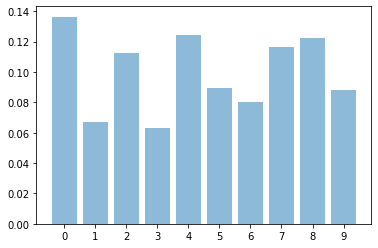

In [31]:
#Generando algunos gráficos de los resultados
from matplotlib.pylab import hist, show
import matplotlib.pyplot as plt
import numpy as np

dist_sum = sum(dist_doc)/nDoc
w=np.arange(0,true_k)
plt.bar(w,height=dist_sum,alpha=0.5,tick_label=w)
show()

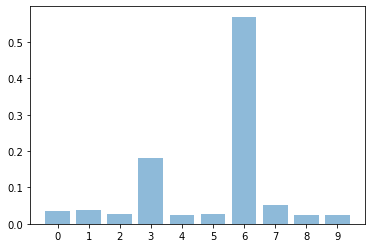

[0.019655373, 0.013381883, 0.013376435, 0.011960818, 0.011255658, 0.010009786, 0.008269836, 0.008224353, 0.007906749, 0.0074704126, 0.0070900386, 0.0066106976, 0.006345077, 0.0059994976, 0.0059742043, 0.0058623636, 0.0056926287, 0.005277821, 0.0051066363, 0.0049417256]


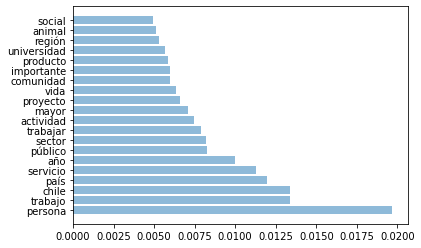

[0.034295157, 0.019097088, 0.015761448, 0.013267029, 0.008556587, 0.008067637, 0.0070990673, 0.006925444, 0.0065516285, 0.006508468, 0.0061306963, 0.005750461, 0.0057392484, 0.005693206, 0.0051302128, 0.0048232833, 0.0043597906, 0.004312605, 0.004286335, 0.0042510335]


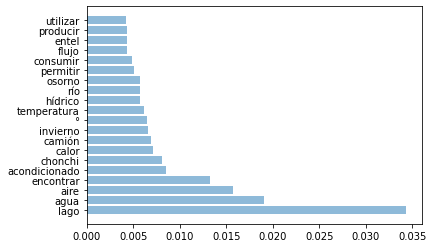

[0.010746229, 0.008377888, 0.006217872, 0.00535267, 0.005333749, 0.0052857753, 0.005253787, 0.0052284533, 0.004992511, 0.004794996, 0.0046889214, 0.004666131, 0.004554377, 0.004155735, 0.004031737, 0.0038946995, 0.003854457, 0.0036830115, 0.0031984814, 0.0030916657]


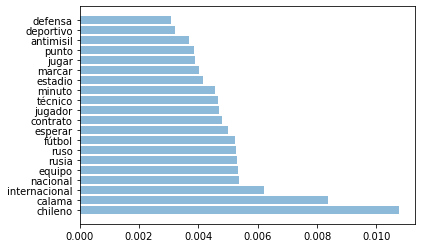

[0.06188621, 0.03938652, 0.034337517, 0.019898137, 0.018249061, 0.016712105, 0.01575469, 0.0149485525, 0.014081166, 0.0140332, 0.013101929, 0.013081629, 0.011327416, 0.00956867, 0.008562254, 0.008145824, 0.0077857305, 0.0076679266, 0.0071676965, 0.0071338783]


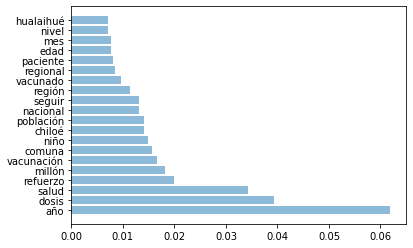

[0.018152963, 0.015679697, 0.007927603, 0.006964319, 0.0068275067, 0.0053118854, 0.0052876654, 0.0052335905, 0.0051090084, 0.0048063495, 0.0045975223, 0.00401205, 0.0039451695, 0.0037799042, 0.0034164907, 0.003385484, 0.0032501356, 0.003081197, 0.0030720104, 0.0030004797]


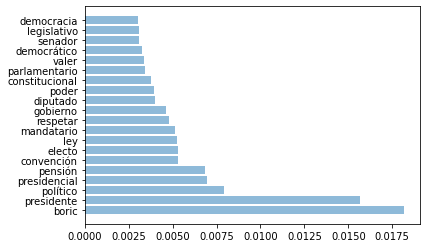

[0.021787087, 0.01892588, 0.01735761, 0.010101709, 0.009537718, 0.009266848, 0.009100693, 0.008465073, 0.00809529, 0.007841878, 0.0052740765, 0.0050210203, 0.004455574, 0.004432275, 0.004377324, 0.004344363, 0.004312052, 0.004111735, 0.0040250625, 0.003921995]


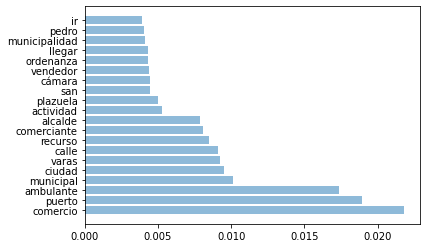

[0.018149786, 0.015403934, 0.012318958, 0.010752674, 0.010332943, 0.008266121, 0.0080927, 0.007645802, 0.0066859615, 0.005910207, 0.005500215, 0.0051213154, 0.0050817276, 0.0044479235, 0.0044018887, 0.0041439715, 0.0039565233, 0.0037061644, 0.003627472, 0.003626443]


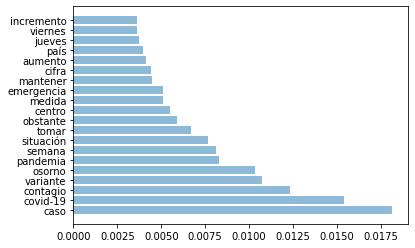

[0.0150042325, 0.008606334, 0.008401616, 0.008150622, 0.007985988, 0.0075033074, 0.006925746, 0.0065606614, 0.0063303546, 0.0054983655, 0.005430029, 0.005420312, 0.005149291, 0.0050330646, 0.0048912102, 0.004398944, 0.004287466, 0.004155604, 0.0040200786, 0.0039434847]


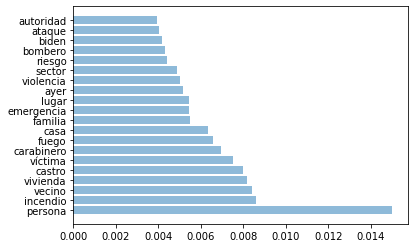

[0.0137245525, 0.007635976, 0.0076104035, 0.0067929802, 0.005257317, 0.00511008, 0.004824169, 0.004799117, 0.0046060053, 0.0044667083, 0.0040672864, 0.003863371, 0.0038381252, 0.0035200403, 0.0034835292, 0.0034611518, 0.0034305295, 0.0032319177, 0.003211927, 0.0032022498]


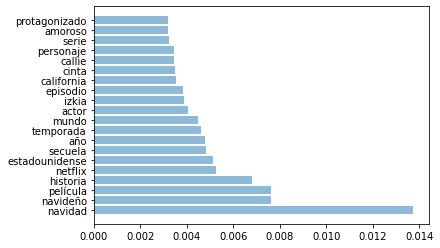

[0.03687227, 0.023376346, 0.014184231, 0.013234814, 0.012836114, 0.011047607, 0.010044246, 0.009260976, 0.008856116, 0.008850227, 0.0074410727, 0.006950714, 0.0065815886, 0.0065674125, 0.0065458026, 0.0064633344, 0.006341155, 0.006289327, 0.0057937345, 0.005054318]


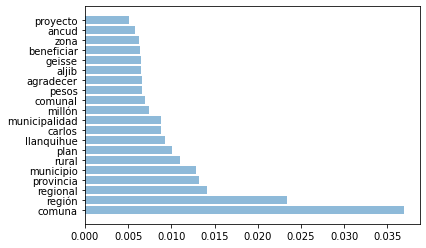

In [32]:
#distribución de tópicos en el documento 100
plt.bar(w,height=dist_doc[51],alpha=0.5,tick_label=w)
show()

#frecuencia de palabras por tópico
n_top_words=20
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(dist_topic):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
        s.append(diccionario[i])
        d.append(topic[i])
    print(d)
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    show()

In [33]:
import pyLDAvis

prepared = pyLDAvis.prepare(doc_lengths = doc_l,
                        vocab = diccionario,
                        term_frequency = term_f,
                        topic_term_dists = dist_topic,
                        doc_topic_dists = dist_doc)
pyLDAvis.display(prepared)

C:\Users\56981\miniconda3\envs\etm\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\56981\miniconda3\envs\etm\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\56981\miniconda3\envs\etm\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modif

In [34]:
topics = etm_instance.get_topics(20)
for i in topics: print(i)
topic_coherence = etm_instance.get_topic_coherence()
print(topic_coherence)
topic_diversity = etm_instance.get_topic_diversity()
print(topic_diversity)

['persona', 'trabajo', 'chile', 'país', 'servicio', 'año', 'público', 'sector', 'trabajar', 'actividad', 'mayor', 'proyecto', 'vida', 'comunidad', 'importante', 'producto', 'universidad', 'región', 'animal', 'social']
['lago', 'agua', 'aire', 'encontrar', 'acondicionado', 'chonchi', 'calor', 'camión', 'invierno', '°', 'temperatura', 'hídrico', 'río', 'osorno', 'permitir', 'consumir', 'flujo', 'entel', 'producir', 'utilizar']
['chileno', 'calama', 'internacional', 'nacional', 'equipo', 'rusia', 'ruso', 'fútbol', 'esperar', 'contrato', 'jugador', 'técnico', 'minuto', 'estadio', 'marcar', 'jugar', 'punto', 'antimisil', 'deportivo', 'defensa']
['año', 'dosis', 'salud', 'refuerzo', 'millón', 'vacunación', 'comuna', 'niño', 'chiloé', 'población', 'nacional', 'seguir', 'región', 'vacunado', 'regional', 'paciente', 'edad', 'mes', 'nivel', 'hualaihué']
['boric', 'presidente', 'político', 'presidencial', 'pensión', 'convención', 'electo', 'ley', 'mandatario', 'respetar', 'gobierno', 'diputado', 